In [2]:
import numpy as np
import matplotlib.pyplot as plt
import aotools


In [3]:

N_p = 512
N_f = 256

D = 0.7
f = 8.41

wvl = 1550e-9

r0 = 0.15
L0,l0 = 10,0.00001

In [7]:
# fov = 2*np.arctan(D/(2*f))

fov_arcsec = 2
fov = np.radians(fov_arcsec/3600)
fov = 0.000145

print('fov',np.degrees(fov))

# sim_size
simPad = 2
sim_size = N_p + 2*simPad


fftOversamp = 1.2

fov 0.0005555555555555556


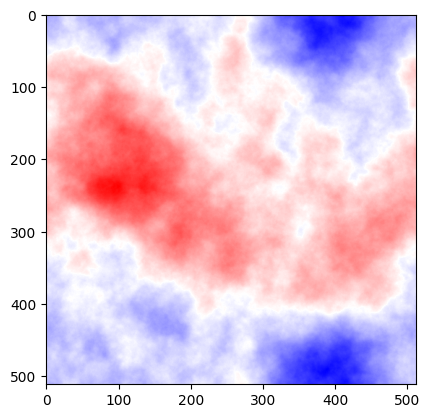

In [8]:
class phaseScreen(object):
    # Using Stategy Pattern to generate the phase screens using and 
    # arbitrary generator function. E.g. Zernike, KL, Kolmogorov, etc.
    def __init__(self, N, strategy, generatorParameters):
        self.N = N
        self.generator = strategy
        self.generatorParameters = generatorParameters
        # Placeholder Attributes
        self.scrn = np.zeros((N,N))
    def setParams(self, **kwargs):
        self.generatorParameters = kwargs
    def generate(self, **kwargs):
        self.scrn = self.generator.generate(self.N, **self.generatorParameters)
        return self.scrn
    def decompose(self, type="zernike",nModes=50):
        if type == "zernike":
            mask = aotools.circle(self.N//2,self.N)
            A = mask*self.scrn
            Z = aotools.zernikeArray(nModes, self.N)
            z = np.array([np.trace(Zj.conj().T @ A ) for Zj in Z]) /self.N**2
            return z
        else:
            # Generate Error
            raise ValueError("Decomposition type not recognised")

# Generator Interface
class generatorStrategy(object):
    def generate(self, N, **kwargs):
        pass

class finitePhaseScreen(generatorStrategy):
    def generate(self, N, **kwargs):
        # unpack the parameters
        r0 = kwargs['r0']
        delta = kwargs['delta']
        L0,l0 = kwargs['L0'], kwargs['l0']
        subHarmonics = kwargs['subHarmonics']
        if subHarmonics == True:
            screen = aotools.turbulence.phasescreen.ft_sh_phase_screen(r0, N, delta, L0, l0)
        else:
            screen = aotools.turbulence.phasescreen.ft_phase_screen(r0, N, delta, L0, l0)
        return screen

finitePhaseScreenParms = {'r0': r0, 'delta': D/N_p, 'L0': L0, 'l0': l0, 'subHarmonics': False}
phaseScreenGenerator = phaseScreen(N_p, finitePhaseScreen(), finitePhaseScreenParms)
    


P = phaseScreenGenerator.generate()
plt.imshow(P,cmap='bwr')

In [9]:

FovPxlNo = (np.round(D*fov/wvl)).astype(int)
print(f'FovPxlNo: {FovPxlNo}')

crop_fov_factor = 1 + N_p//FovPxlNo
print(f'crop_fov_factor: {crop_fov_factor}')

fov_crop_elements = (FovPxlNo*crop_fov_factor-FovPxlNo)//2
print(f'fov_crop_elements: {fov_crop_elements}')

FovPxlNo *= crop_fov_factor
print(f'FovPxlNo: {FovPxlNo}')



padFOVPxNo = np.round(FovPxlNo * simPad/N_p).astype(int) 
print(f'padFOVPxNo: {padFOVPxNo}')


fov_sim_pad = int((padFOVPxNo - FovPxlNo) // 2.)
print(f'fov_sim_pad: {fov_sim_pad}')

FFTPaddig = N_f * fftOversamp
print(f'FFTPaddig: {FFTPaddig}')




print(f"FFTPaddig < FovPxlNo: {FFTPaddig < FovPxlNo}")
        # if self.FFTPadding < self.FOVPxlNo:
        #     while self.FFTPadding < self.FOVPxlNo:
        #         self.config.fftOversamp += 1
        #         self.FFTPadding\
        #             = self.nx_pixels * self.config.fftOversamp
if FFTPaddig < FovPxlNo:
    while FFTPaddig < FovPxlNo:
        fftOversamp += 1
        FFTPaddig = N_f * fftOversamp
        print(f'FFTPaddig: {FFTPaddig}')
        print(f'fftOversamp: {fftOversamp}')

        # self.fft_crop_elements = (self.FFTPadding * self.crop_fov_factor - self.FFTPadding)//2
        # self.FFTPadding *= self.crop_fov_factor
fftCropElements = (FFTPaddig * crop_fov_factor - FFTPaddig) // 2

FFTPaddig *= crop_fov_factor

FFTPaddig = np.round(FFTPaddig).astype(int)

print(f'fftCropElements: {fftCropElements}')
print(f'FFTPaddig: {FFTPaddig}')

FFTInputArray = np.zeros((FFTPaddig,FFTPaddig))
FFTOutputArray = np.zeros((FFTPaddig,FFTPaddig))



FovPxlNo: 4
crop_fov_factor: 129
fov_crop_elements: 256
FovPxlNo: 516
padFOVPxNo: 2
fov_sim_pad: -257
FFTPaddig: 307.2
FFTPaddig < FovPxlNo: True
FFTPaddig: 563.2
fftOversamp: 2.2
fftCropElements: 36044.0
FFTPaddig: 72653


MemoryError: Unable to allocate 39.3 GiB for an array with shape (72653, 72653) and data type float64

In [68]:

E_p = np.exp(1j*P)

E_fov = E_p[fov_sim_pad:-fov_sim_pad, fov_sim_pad:-fov_sim_pad]

print(f"E_p.shape: {E_p.shape}, E_fov.shape: {E_fov.shape}")


FFTInputArray[:N_p,:N_p] = E_fov
FFTOutputArray = np.fft.fftshift(np.fft.fft2(FFTInputArray))

E_f = FFTOutputArray 

plt.imshow(np.angle(E_f),cmap='bwr')

E_p.shape: (512, 512), E_fov.shape: (512, 512)


/tmp/ipykernel_201809/2813059650.py:8: ComplexWarning: Casting complex values to real discards the imaginary part
  FFTInputArray[:N_p,:N_p] = E_fov
